<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

In [31]:
import os
import time
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
print(tf.__version__)
tf.keras.utils.set_random_seed(seed=42)
tf.config.list_physical_devices()

2.16.2


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

inputs = tf.keras.Input(shape=(28, 28), dtype=tf.float32)
h = tf.keras.layers.Rescaling(scale=1./255)(inputs)
outputs = tf.keras.layers.Reshape(target_shape=(784,))(h)
preprocessing_model = tf.keras.Model(inputs=inputs, outputs=outputs)

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=64)
    ds = ds.map(map_func=lambda x, y: (preprocessing_model(x), y),
        num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds

ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)
ds_test.element_spec

(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

In [32]:
@keras.saving.register_keras_serializable()
class CustomModel(tf.keras.Model):

    @tf.function
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(inputs=x, training=True)
            loss = self.compute_loss(y=y, y_pred=y_pred)

        trainable_vars = self.trainable_variables
        grads = tape.gradient(target=loss, sources=trainable_vars)
        self.optimizer.apply_gradients(grads_and_vars=zip(
            grads, trainable_vars))

        for metric in self.metrics:
            if metric.name=='loss':
                metric.update_state(values=loss)
            else:
                metric.update_state(y_true=y, y_pred=y_pred)

        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        x, y = data

        y_pred = self(inputs=x, training=False)
        loss = self.compute_loss(y=y, y_pred=y_pred)

        for metric in self.metrics:
            if metric.name=='loss':
                metric.update_state(values=loss)
            else:
                metric.update_state(y_true=y, y_pred=y_pred)

        return {m.name: m.result() for m in self.metrics}

inputs = tf.keras.Input(shape=(784,))
h = tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu,
    kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))(inputs)
h = tf.keras.layers.Dropout(rate=0.2)(h)
outputs = tf.keras.layers.Dense(units=10,
    activation=tf.keras.activations.softmax)(h)
training_model = CustomModel(inputs=inputs, outputs=outputs)
training_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(name='loss'),
    optimizer = tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)
training_model.summary()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
    patience=1, factor=0.9)

start_time = time.time()
history = training_model.fit(x=ds_train, validation_data=ds_test,
    epochs=10, callbacks=[reduce_lr], verbose=0)
print('Training duration: %.2fs'%(time.time() - start_time))

Model: "custom_model_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

Training duration: 17.24s


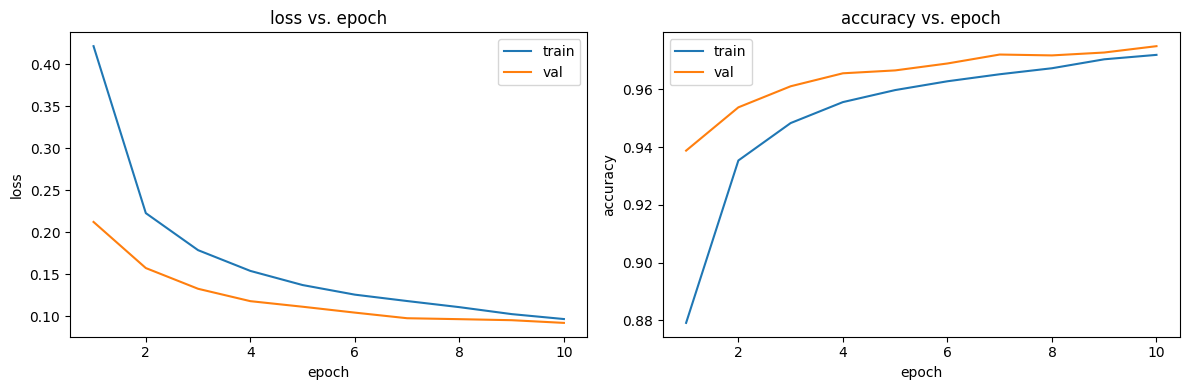

In [33]:
df_history = pd.DataFrame(history.history)
df_history['epoch'] = df_history.index + 1

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for ax, m in zip(axes, ["loss", "accuracy"]):
    g = sns.lineplot(ax=ax, data=df_history, label='train',
        x='epoch', y=f'{m}')
    g = sns.lineplot(ax=ax, data=df_history, label='val',
        x='epoch', y=f'val_{m}')
    ax.legend(loc="best")
    ax.set_xlabel(xlabel="epoch")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

In [36]:
inputs = preprocessing_model.input
outputs = training_model(preprocessing_model(inputs))
inference_model = tf.keras.Model(inputs=inputs, outputs=outputs)
os.makedirs('models', exist_ok=True)
inference_model.save('models/model.keras')

idx = 99
x_pred = np.reshape(a=x_test[idx], newshape=(1, 28, 28))
inference_model = tf.keras.models.load_model('models/model.keras')
y_pred = inference_model(x_pred)
print('y_true:', y_test[idx], 'y_pred:', np.argmax(y_pred))

y_true: 9 y_pred: 9
